## 3) 인구 관련

In [107]:
df = population.set_index('id')

### 청년층 비율

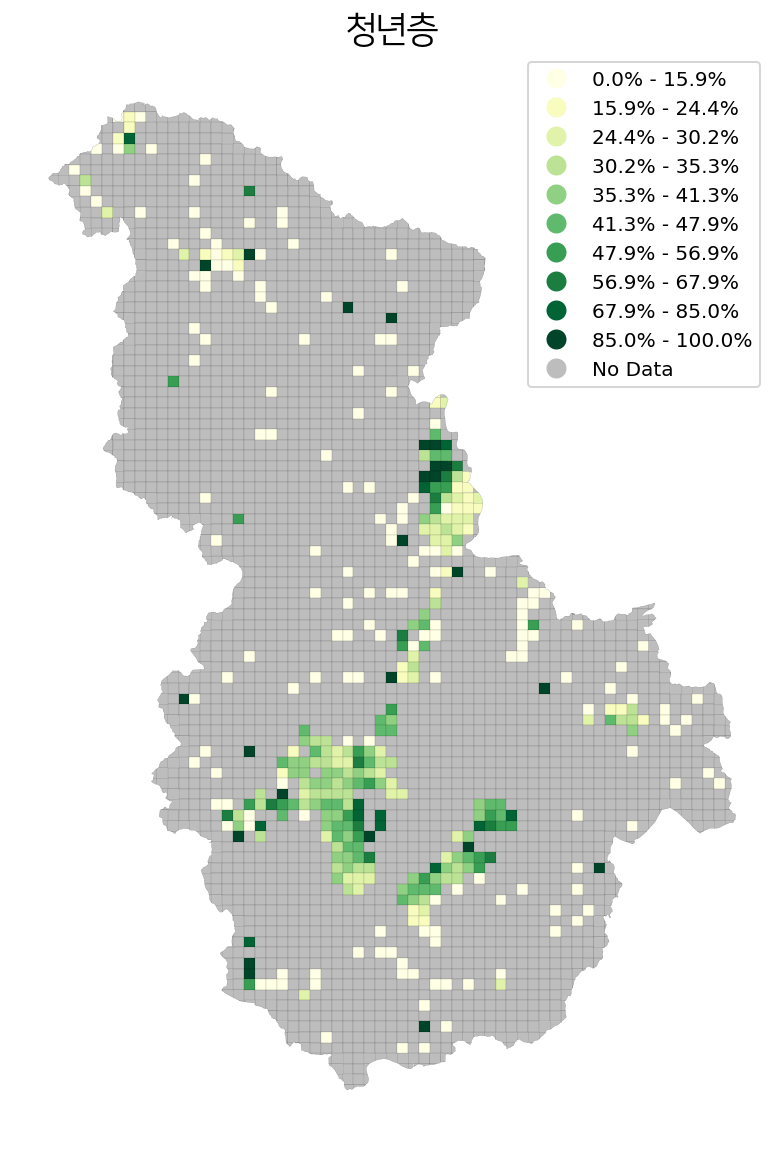

In [108]:
# 2020년 데이터만 추출

df2020 = df[['202010_20대_거주인구수','202010_30대_거주인구수','202010_40대_거주인구수',
        '202010_50대_거주인구수','202010_60대_거주인구수','202010_70대_거주인구수',
        '202010_80대_거주인구수','202010_90대_거주인구수','202010_100세이상_거주인구수']].fillna(0)

# 청년층 비율 계산
df2020['총합'] = df2020.sum(axis=1)
df2020['청년층비율'] = 100*(df2020['202010_20대_거주인구수']+df2020['202010_30대_거주인구수'])/df2020['총합']
df2020['노년층비율'] = 100*(df2020['202010_70대_거주인구수']+df2020['202010_80대_거주인구수']+
                       df2020['202010_90대_거주인구수']+df2020['202010_100세이상_거주인구수'])/df2020['총합']
df2020 = df2020.reset_index()

# 시각화
df2020 = pd.merge(df2020,geo,on='id',how='outer')
df2020 = GeoDataFrame(df2020)
plot_grid_map(df2020, col = '청년층비율' , title = '청년층',mode = 'cont_classify', k=10,
              c_mode = 'FisherJenks', colors = 'YlGn', percen = True)

In [109]:
pop2020 = df2020

### 노년층 비율

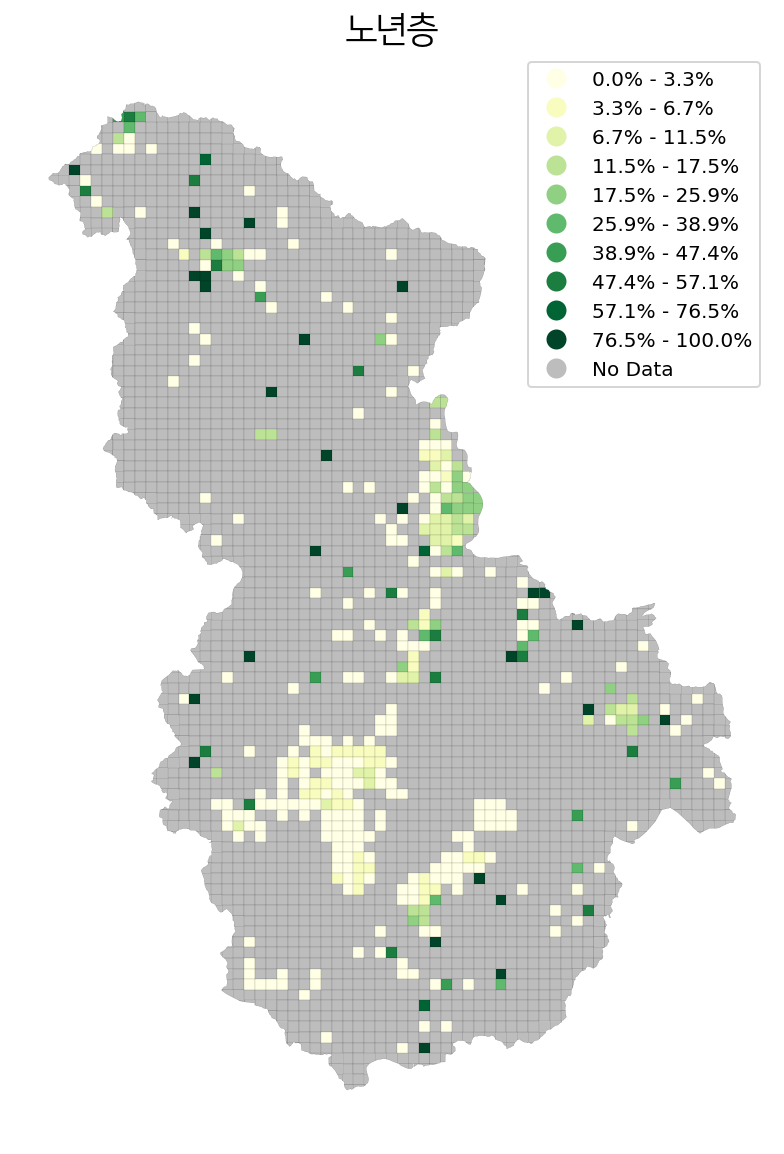

In [110]:
# 시각화
plot_grid_map(df2020, col = '노년층비율' , title = '노년층',mode = 'cont_classify', k=10,
              c_mode = 'FisherJenks', colors = 'YlGn', percen = True)

### 전입자 수, 전출자 수 데이터

In [111]:
# 전입자 수 데이터
dfin = data20.groupby(['년월','세종전입행정동']).sum().unstack()
dfin.columns = dfin.columns.droplevel(0)
dfin = dfin.rename_axis(None, axis=1).fillna(0)

# 전출자 수 데이터
dfout = data21.groupby(['년월','세종전출행정동']).sum().unstack()
dfout.columns = dfout.columns.droplevel(0)
dfout = dfout.rename_axis(None, axis=1).fillna(0)

# 인덱스 datetime 으로 변환
dfin.index = pd.to_datetime(dfin.index, format='%Y%m')
dfout.index = pd.to_datetime(dfout.index, format='%Y%m')

In [112]:
#동별 순 전입자수 시각화
from plotly.subplots import make_subplots

df= dfin - dfout
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
for i in df.columns.tolist():
    fig.add_trace(go.Scatter(x=df.index,y=df[i],
             mode='lines', name=i))
fig.update_layout(title='순 유입(전입자 수 - 전출자 수)', plot_bgcolor='#F8F7F1')
fig.show()

### 내지인 거래 비율

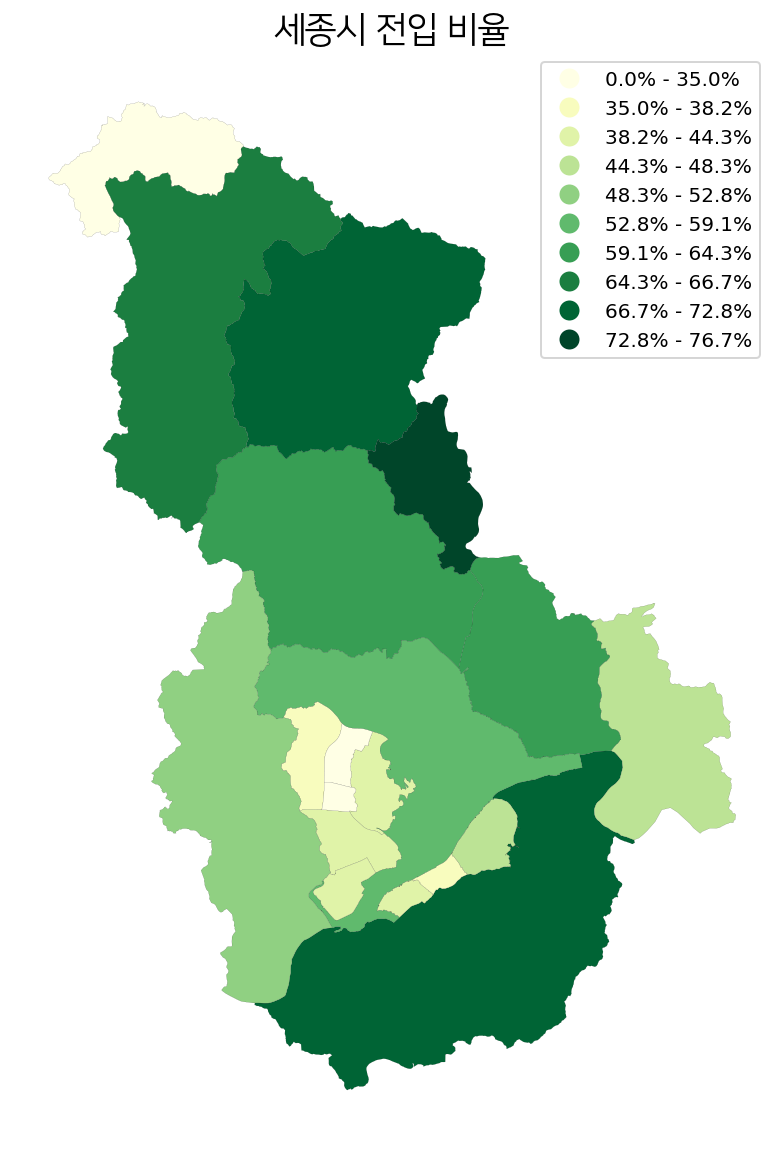

In [113]:
# 전출 동네가 세종시인 비율 구하기
data20['전출 동네'] = data20['전출시군구'] + ' ' + data20['전출읍면동']
df = data20.groupby(['세종전입행정동','전출시군구']).sum()['전입자수'].unstack().transpose().fillna(0)
df2 = df.transpose()
df2['세종비율'] = 100*df.loc['세종특별자치시']/df.sum()
df = DataFrame(df2['세종비율']).reset_index()

# Data Merging
df2 = pd.merge(df,data32,left_on='세종전입행정동',right_on='ADM_DR_NM',how='outer')
df2 = GeoDataFrame(df2)

# 시각화
plot_grid_map(df2, col = '세종비율', title = '세종시 전입 비율',mode = 'cont_classify', k=10,
              c_mode = 'FisherJenks', colors = 'YlGn', percen = True)

### 전출시도별 전입자수 추이

In [114]:
# 전출시도별 전입자수 추이
data20_2 = data20.groupby(["년월","전출시"]).count().reset_index()
data20_2['년월'] = pd.to_datetime(data20_2['년월'], format='%Y%m')

table = data20_2.pivot_table(index = ['년월'],columns=['전출시'])
provinces = data20_2['전출시'].unique()

fig = make_subplots(rows=6, cols=3,horizontal_spacing=0.05,subplot_titles=([f'<b>{prov}</b>' for prov in provinces]))

for i, province in enumerate(provinces):
    row, col, legend = i//3 + 1, i%3 + 1, False
    if i == len(provinces)-1 :
        legend = True
    fig.add_trace(go.Scatter(x=table.index,y= table['전입자수'][province],
                 mode='lines', name=col,showlegend=False), row=row, col=col)

fig.update_layout(title='<b>시도별 세종시 전입자수 추이</b>',
                  height = 2000,
                  legend=dict(x=0.7, y=0.05, traceorder="normal",
                             font=dict(family="sans-serif", size=18)), plot_bgcolor='#F8F7F1')    
for i in fig['layout']['annotations']:
    i['font'] = dict(size=9)

fig.show()

In [115]:
data20_2 = data20_2.groupby('년월').sum().reset_index()
fig = px.bar(data20_2,x='년월',y = '전입자수', color_discrete_sequence=['navy'])
fig.update_layout(title='<b>전출시도별 전입자수 추이</b>', plot_bgcolor='#F8F7F1')
fig.show()

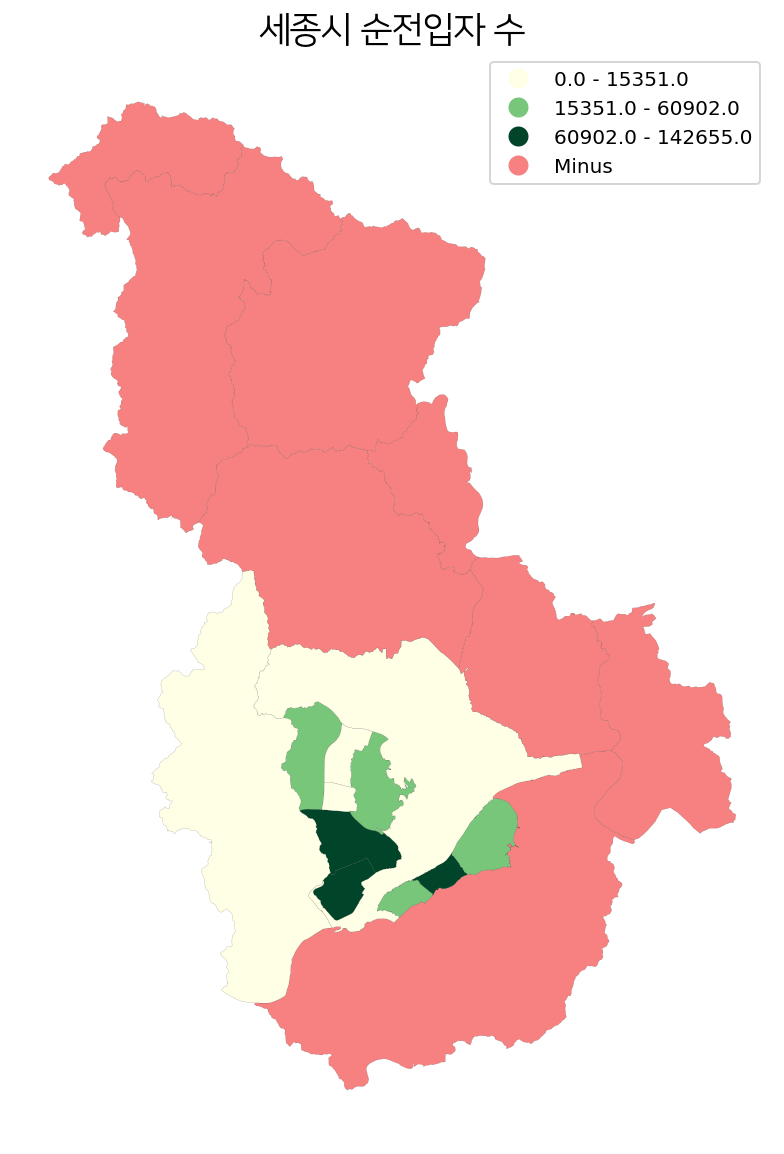

In [116]:
# 순 전입자 수 구하기
df = dfin - dfout
df = DataFrame(df.sum()).reset_index()

# Data Merging
df2 = pd.merge(df,data32,left_on='index',right_on='ADM_DR_NM',how='outer')
df2 = GeoDataFrame(df2)
popin = df2

# 시각화
plot_grid_map(df2, col = 0 , title = '세종시 순전입자 수',mode = 'cont_classify', k=3,
              c_mode = 'FisherJenks', colors = 'YlGn', percen = False)

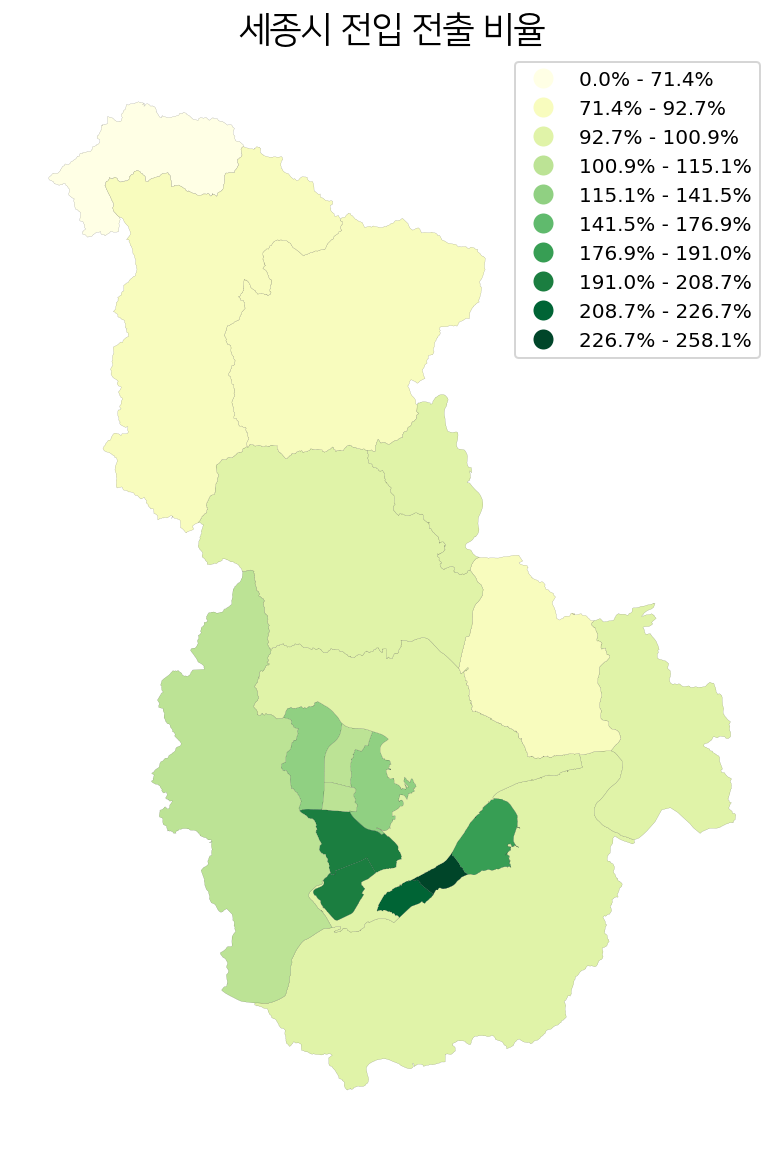

In [117]:
# 전입/전출 비율 구하기
df = 100*dfin.sum()/dfout.sum()
df = DataFrame(df).reset_index()

# Data Merging
df2 = pd.merge(df,data32,left_on='index',right_on='ADM_DR_NM',how='outer')
df2 = GeoDataFrame(df2)

# 시각화
plot_grid_map(df2, col = 0 , title = '세종시 전입 전출 비율',mode = 'cont_classify', k=10,
              c_mode = 'FisherJenks', colors = 'YlGn', percen = True)

### 읍면동 별 인구 수

In [118]:
df = data22[['읍면동','202012_남자(총_거주자_수)','202012_여자(총_거주자_수)']]
emd = []
for i in range(len(df)):
    if df['읍면동'][i][2] == '면':
        emd.append('면')
    elif df['읍면동'][i][2] == '원':
        emd.append('읍')
        
    elif df['읍면동'][i][2] == '동':
        emd.append('동')
    else:
        emd.append('세종')
df['emd'] = emd
df['계'] = df['202012_남자(총_거주자_수)']+df['202012_여자(총_거주자_수)']

In [119]:
dfdf = df.drop(0)
dfdf = dfdf.groupby('emd').sum().reset_index()
labels = dfdf['emd']
values = dfdf['계']

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3, marker_colors=['#F5D042', '#0A174E', '#09663D'])])
fig.update_layout(legend=dict(xanchor="left",x=0.65),title='세종시 인구 수 비율',font=dict(size=18))
fig.show()

In [120]:
labels = ['남자', '여자']
values = [176998, 177707]

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3, marker_colors=['b', 'r'])])
fig.update_layout(legend=dict(xanchor="left",x=0.65),title='세종시 인구 수 비율',font=dict(size=18))
fig.show()

### 읍면동 별 가구 수

In [121]:
# 읍면동으로 나누기
df = data28
df['읍면동'] = df['읍면동'].str.replace(" ", "") # 공백 제거

emd = []
for i in range(len(df)):
    if df['읍면동'][i][2] == '면':
        emd.append('면')
    elif df['읍면동'][i][2] == '원':
        emd.append('읍')
    elif df['읍면동'][i][2] == '동':
        emd.append('동')
df['emd'] = emd

In [122]:
import plotly.graph_objects as go

dfdf = df.groupby('emd').sum().reset_index()
labels = dfdf['emd']
values = dfdf['계']

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3, marker_colors=['#F5D042', '#0A174E', '#09663D'])])
fig.update_layout(legend=dict(xanchor="left",x=0.65), title='세종시 가구 수 비율',font=dict(size=18))
fig.show()

### 1인 가구 비율

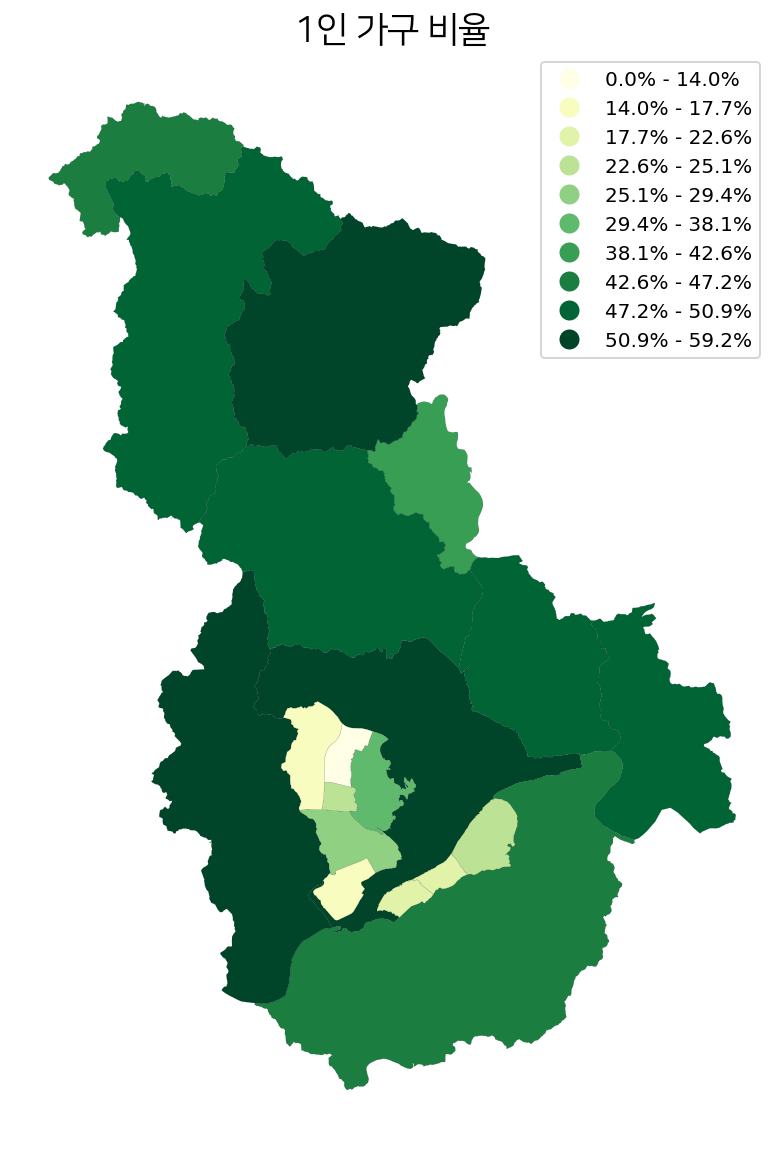

In [123]:
df = data28
df['읍면동'] = df['읍면동'].str.replace(" ", "") # 공백 제거

# 1인가구 비율 구하기
df['1인가구 비율'] = 100*df['1인']/df['계']

# 핵가족
df['핵가족 비율'] = 100*(df['2인']+df['3인']+df['5인'])/df['계']

# 대가족
df['대가족 비율'] = 100*(df['6인']+df['7인']+df['8인']+df['9인']+df['10인이상'])/df['계']

# Data Merging
df2 = pd.merge(df,data32,left_on='읍면동',right_on='ADM_DR_NM',how='outer')
df2 = GeoDataFrame(df2)

# 시각화
plot_grid_map(df2, col = '1인가구 비율' , title = '1인 가구 비율',mode = 'cont_classify', k=10,
              c_mode = 'FisherJenks', colors = 'YlGn', percen = True)

### 핵가족 가구 비율

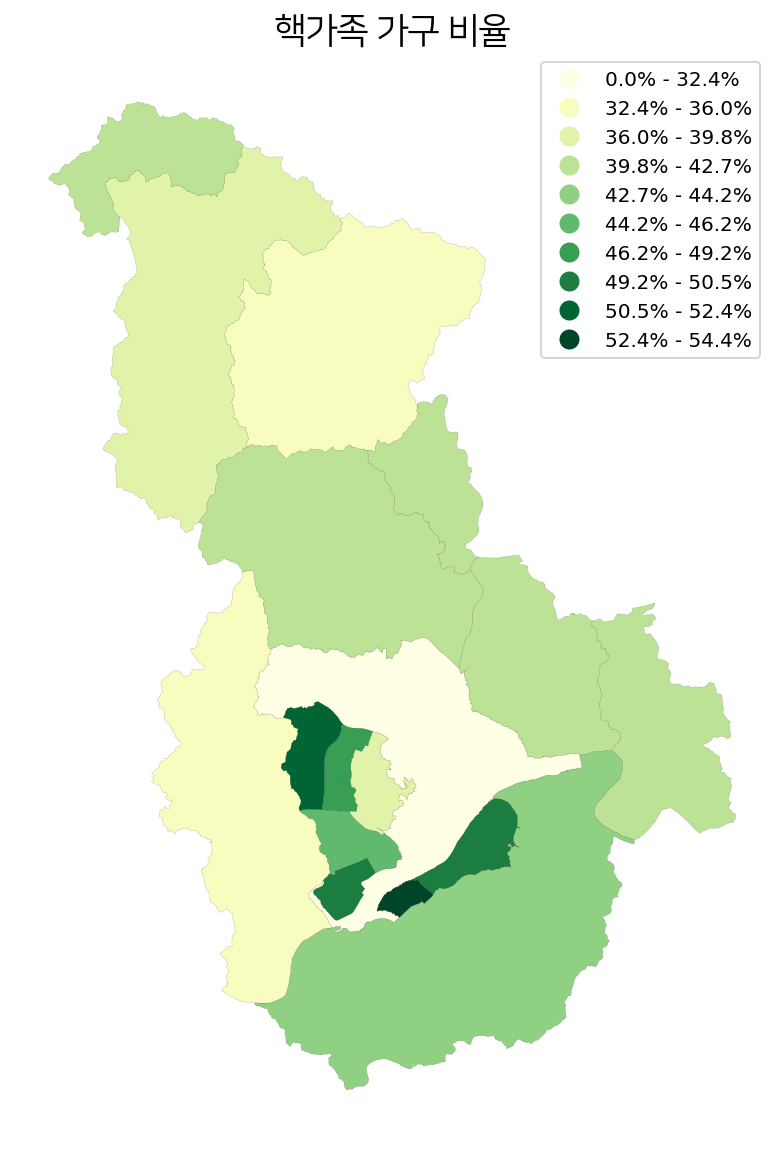

In [124]:
# 시각화
plot_grid_map(df2, col = '핵가족 비율' , title = '핵가족 가구 비율',mode = 'cont_classify', k=10,
              c_mode = 'FisherJenks', colors = 'YlGn', percen = True)

### 대가족 가구 비율

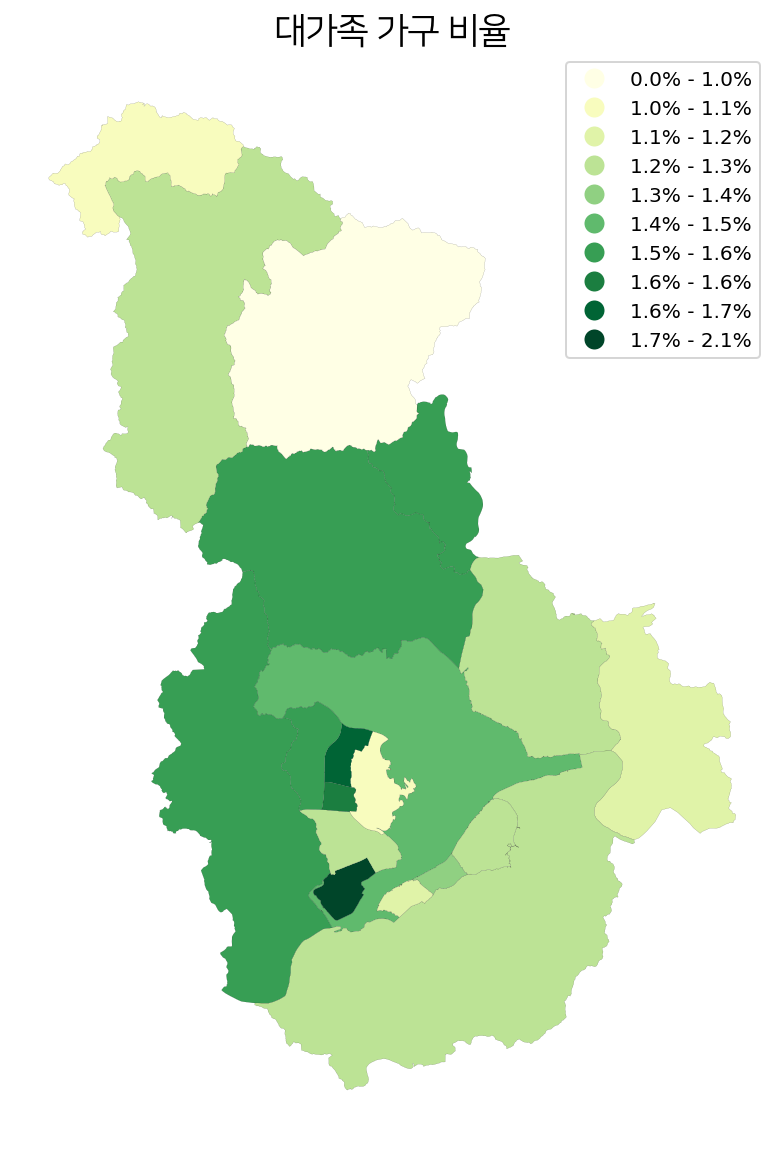

In [125]:
# 시각화
plot_grid_map(df2, col = '대가족 비율' , title = '대가족 가구 비율',mode = 'cont_classify', k=10,
              c_mode = 'FisherJenks', colors = 'YlGn', percen = True)

### 거주 의사 데이터

In [126]:
dat29 = data29.copy()
dat29['긍정'] =  data29['매우 그런편임']+ data29['어느정도 그런편임']
dat29['부정'] =  data29['약간 그렇지 않은편임']+ data29['전혀 그렇지 않은편임']
dat29 = dat29.drop(['매우 그런편임','어느정도 그런편임','전혀 그렇지 않은편임','약간 그렇지 않은편임'],axis =1)

In [127]:
# 데이터, 변수별 분리
data29_dur = dat29.loc[6:7] # 거주기간별
data29_mar = dat29.loc[25:27] # 결혼여부별 
data29_hom = dat29.loc[38:40] # 주거점유형태별

### 거주기간별 향후 거주 의사 

In [128]:
df = data29_dur.transpose().reset_index().drop([0,1])
for i in range(2):
    # Use `hole` to create a donut-like pie chart
    fig = go.Figure(data=[go.Pie(labels=df['index'], values=df[i+6], hole=.4, marker_colors=['#F5D042', '#0A174E', '#09663D'])])
    fig.update_layout(legend=dict(xanchor="left",x=0.65), title='향후 거주 의사',font=dict(size=18))
    fig.show()

### 주거점유형태별 향후 거주 의사 

In [129]:
df = data29_hom.transpose().reset_index().drop([0,1])
for i in range(3):
    # Use `hole` to create a donut-like pie chart
    fig = go.Figure(data=[go.Pie(labels=df['index'], values=df[i+38], hole=.4, marker_colors=['#F5D042', '#0A174E', '#09663D'])])
    fig.update_layout(legend=dict(xanchor="left",x=0.65), title='향후 거주 의사',font=dict(size=18))
    fig.show()